In [1]:
# import utilities to retrieve the dataset from Kaggle

from google.colab import files
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ikarus777/best-artworks-of-all-time --unzip

Saving kaggle.json to kaggle.json
100% 2.28G/2.29G [00:28<00:00, 109MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.8MB/s]


In [2]:
!mkdir /content/images/images/Albrecht_Dürer/
import os
for filename in os.listdir('/content/images/images/Albrecht_DuΓòá├¬rer'):
  p = '/content/images/images/Albrecht_DuΓòá├¬rer/' + filename
  ! cp {p} '/content/images/images/Albrecht_Dürer/'
for filename in os.listdir('/content/images/images/Albrecht_Du╠êrer'):
  p = '/content/images/images/Albrecht_Du╠êrer/' + filename
  ! cp {p} '/content/images/images/Albrecht_Dürer/'

!rm -rf '/content/images/images/Albrecht_DuΓòá├¬rer'
!rm -rf '/content/images/images/Albrecht_Du╠êrer'

# Pytorch DCGAN Art Generation
### The notebook is used to train a simple DCGAN model and extended further to build an NFT platform on Ethereum blockchain. Full project is in github [here](https://github.com/MdTeach/crypto_art)

In [3]:
import os
from glob import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 as cv
import imageio

In [4]:
data_dir = "/content/"
image_dir = "/content/images/images/Henri_Matisse"
image_root = "/content/images/images"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ",device)

Device is  cpu


## 1) Sample Images Plots

Sample arts


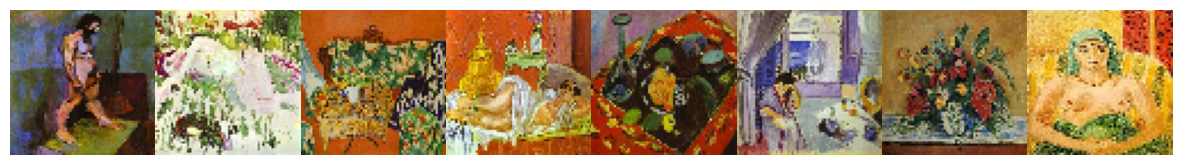

In [5]:
no_plots = 8*1
images = glob(f'{image_dir}/*')

plt.rcParams['figure.figsize'] = (15, 15)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample arts")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    sample_img = cv.resize(sample_img,(64,64))
    plt.subplot(1, 8, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB))
plt.show()

## 2) Torch DataLoader and Image Preprocessing

In [6]:
import torch
from torchvision import datasets
from torchvision import transforms

# helper display function
def tensor_imshow(img,dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
def get_dataloader(batch_size, image_size, data_dir=image_dir, num_workers=3):
    target_old_to_new = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 1, 6: 5, 7: 1, 8: 6, 9: 5, 10: 1, 11: 7, 12: 8, 13: 9, 14: 10, 15: 10, 16: 11, 17: 12, 18: 13, 19: 8, 20: 7, 21: 1, 22: 11, 23: 12, 24: 0, 25: 14, 26: 0, 27: 15, 28: 16, 29: 17, 30: 11, 31: 17, 32: 8, 33: 18, 34: 12, 35: 8, 36: 2, 37: 5, 38: 1, 39: 19, 40: 0, 41: 17, 42: 5, 43: 15, 44: 15, 45: 20, 46: 17, 47: 2, 48: 12, 49: 10}

    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        # We tranform our image values to be between -1 and 1 (the range of the tanh activation)
        transforms.Normalize(*stats), # 
    ])
    target_transform = transforms.Lambda(lambda y: target_old_to_new[y])
    
    dataset = datasets.ImageFolder(root=data_dir, transform=transform, target_transform=target_transform)
    
    df = pd.read_csv("/content/artists.csv")

    artist_to_genre = {}
    for artist in dataset.classes:
        if df[df['name'] == artist.replace('_', ' ')].genre.values[0].find(',') != -1:
            val = df[df['name'] == artist.replace('_', ' ')].genre.values[0].split(',')[0]
        else:
            val = df[df['name'] == artist.replace('_', ' ')].genre.values[0]
        artist_to_genre[artist] = val

    genre_dict = {}
    new_classes = []
    idx = 0
    for artist, genre in artist_to_genre.items():
        if genre not in genre_dict:
            genre_dict[genre] = idx
            new_classes.append(genre)
            idx += 1

    dataset.classes = new_classes
    dataset.class_to_idx = genre_dict

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    print("Classes are : ", dataset.classes)
    print("Number of classes : ", len(dataset.classes))
    print("Number of images : ", len(dataset))

    return data_loader, dataset.class_to_idx

Classes are :  ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance']
Number of classes :  21
Number of images :  8774


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


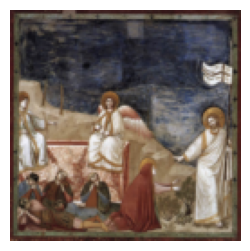

In [8]:
# Testing the dataloader
batch_size, image_size = 32, 128
train_loader, class_to_idx = get_dataloader(batch_size,image_size,image_root)
dataiter = iter(train_loader)

NUM_CLASSES = len(class_to_idx)

img,_ = next(dataiter)
sample_img = img[-1]
tensor_imshow(sample_img)

## 3) Building Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, num_classes=NUM_CLASSES, in_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.in_chan = in_chan
        self.hidden_dim = hidden_dim
        
        self.label_emb = nn.Embedding(num_classes, 50)

        self.generator = nn.Sequential(
            self.make_gen_block(self.z_dim + self.label_emb.embedding_dim, 512, stride=1, padding=0),
            self.make_gen_block(512,256),
            self.make_gen_block(256,128),
            self.make_gen_block(128,64),
            self.make_gen_block(64,32),
            self.make_gen_block(32, in_chan,final_layer=True),
        )
    
    def make_gen_block(self,in_channels,op_channels,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels,op_channels,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_channels))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self, noise, labels):
        t = torch.cat([noise, self.label_emb(labels)], dim=1)
        x = t.view(-1, self.z_dim + self.label_emb.embedding_dim, 1, 1)
        return self.generator(x)

    def get_noise(self, n_samples, z_dim, device):
        return torch.randn(n_samples, z_dim, device=device)
    
    def get_fake(self, n_samples, z_dim, device):
        noise = self.get_noise(n_samples=n_samples, z_dim=z_dim, device=device)
        fake_labels = torch.randint(0, NUM_CLASSES, (n_samples,), device=device)
        return noise, fake_labels

In [11]:
#Testing Genarator
g = Generator(z_dim=10, in_chan=3, hidden_dim=64)
fake_img, fake_label = g.get_fake(n_samples=5, z_dim=10, device=device)
img = g(fake_img, fake_label)
print(img.shape)
assert img.shape == (5,3,128,128), "Generator Output Images shape incorrect"
print("Generator Test passed!!")

torch.Size([5, 3, 128, 128])
Generator Test passed!!


In [12]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, conv_dim=64, image_size=128, num_classes=NUM_CLASSES):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        self.num_classes = num_classes
        
        self.label_emb = nn.Embedding(num_classes, 50)

        self.disc_cnn = nn.Sequential(
            self.make_disc_block(im_chan + self.label_emb.embedding_dim,32),
            self.make_disc_block(32,64),
            self.make_disc_block(64,128),
            self.make_disc_block(128,256),
            self.make_disc_block(256,512),
            self.make_disc_block(512,1, padding=0, final_layer=True),
        )
        
        
    def make_disc_block(self,in_chan,op_chan,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.Conv2d(in_chan, op_chan, kernel_size, stride, padding, bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    
    def forward(self, image, labels):
        x = torch.cat([image, self.label_emb(labels).unsqueeze(2).unsqueeze(3).repeat(1,1,self.image_size,self.image_size)], dim=1)
        pred = self.disc_cnn(x)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [13]:
#Testing Discriminator
d = Discriminator(im_chan=3,conv_dim=128,image_size=128)
# print(d)
img = torch.rand(4,3,128,128)
fake_labels = torch.randint(0, NUM_CLASSES, (4,))
d_op = d(img, fake_labels)
assert d_op.shape == (4,1),"Discrimenator Output Images shape incorrect"
print("Discriminator test passed!!")

Discriminator test passed!!


Initalizing the weights of the network as mentioned in [**DCGAN paper**](https://arxiv.org/pdf/1511.06434.pdf).<br> Having all weights initialized from a zero-centered Normal distribution with standard deviation 0.02.

In [14]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

## 4) Defining Loss

In [15]:
def real_loss(D_out, device):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size,device=device)*0.9 # real labels = 1 and lable smoothing => 0.9
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out, device):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size,device=device) # fake labels = 0
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

## 7) Train Function

In [16]:
def print_tensor_images(images_tensor, titles=None):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx, image in enumerate(npimgs):
      if titles:
        plt.title(titles)
      plt.subplot(1, 8, idx+1)
      plt.axis('off')
      #dnorm
      image = image * 0.5 + 0.5
      plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

def train(D, G, n_epochs, dataloader, d_optimizer, g_optimizer, z_dim, device, print_every=50):
    
    print("Entered training...")
    ## Get some fixed data for sampling.##      
    sample_size = 8
    fixed_z, fixed_labels = G.get_fake(n_samples=sample_size, z_dim=z_dim, device=device)

    for epoch in range(1, n_epochs+1):
        for batch_i, (real_images, real_labels) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            

            ### Discriminator part ###
            d_optimizer.zero_grad()

            # loss on real image
            d_real_op = D(real_images, real_labels)
            d_real_loss = real_loss(d_real_op, device=device)
            
            # loss on fake image
            noise, fake_labels = G.get_fake(n_samples=batch_size, z_dim=z_dim, device=device)
            fake_images = G(noise, fake_labels)
            d_fake_op = D(fake_images, fake_labels)
            d_fake_loss = fake_loss(d_fake_op, device=device)
            
            # total loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            ### Generator part ###
            g_optimizer.zero_grad()

            noise, fake_labels = G.get_fake(n_samples=batch_size, z_dim=z_dim, device=device)
            g_out = G(noise, fake_labels)
            d_out = D(g_out, fake_labels)
            
            g_loss = real_loss(d_out, device=device)
            g_loss.backward()
            g_optimizer.step()
        
        
        print('Epoch [{:3d}/{:3d}] | d_real_loss: {:6.3f} | d_fake_loss: {:6.3f} | g_loss: {:6.3f}'.format(epoch, n_epochs, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z, fixed_labels)
            print_tensor_images(sample_image)
            G.train()

        generated_img = G(fixed_z, fixed_labels).to('cpu').detach()
        images.append(generated_img)
        

## 6) Model & Optimizer Init and Trining

In [17]:
import torch.optim as optim

In [18]:
# hyperparams
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ",device)

z_dim = 100
beta_1 = 0.5
beta_2 = 0.999 

n_epochs = 150
lr = 0.0002

batch_size = 64
image_size = 128

Device is  cpu


In [19]:
# data init
dataloader, classes = get_dataloader(batch_size, image_size, image_root)

# model init
gen = Generator(z_dim, in_chan=3, hidden_dim=64, num_classes=len(classes)).to(device)
disc = Discriminator(im_chan=3, conv_dim=64, image_size=image_size, num_classes=len(classes)).to(device)

# optimizer init
g_optimizer = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
d_optimizer = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Classes are :  ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance']
Number of classes :  21
Number of images :  8774


In [ ]:
n_epochs = 150
history = train(
    disc,gen,
    n_epochs,dataloader,
    d_optimizer,g_optimizer,
    z_dim,
    print_every=10,
    device=device,
)

Entered training...
Epoch [  1/150] | d_real_loss:  0.392 | d_fake_loss:  0.889 | g_loss:  4.643


In [ ]:
def save_model(gen, disc, file_name):
    gen = gen.to('cpu')
    torch.save(gen.state_dict(),"gen_epoch_" + str(n_epochs) + ".pth")
    disc = disc.to('cpu')
    torch.save(disc.state_dict(),"disc_epoch_" + str(n_epochs) + ".pth")

save_model(gen, disc, "kaggle")

In [ ]:
# function to plot history for metrics

def plot_history(history, modelName):
  for metric in list(history.history.keys()):
    plt.plot(history.history[metric])
  plt.title(modelName)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(list(history.history.keys()), loc='upper left')
  plt.show()

plot_history(history, "CGAN")

AttributeError: ignored

In [ ]:
# save the generated images as GIF file
imgs = [np.array(transforms.ToPILImage(img)) for img in images]
imageio.mimsave('/content/generator_images.gif', imgs)

ValueError: ignored

<ipython-input-35-5d4ad89ad492>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 8, idx+1)


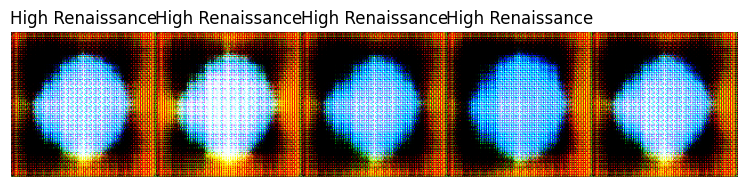

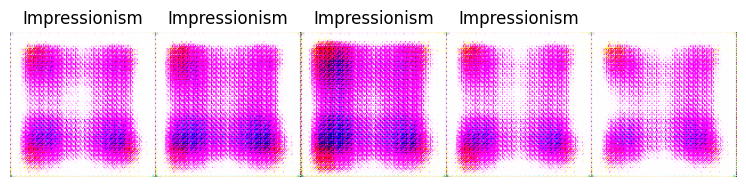

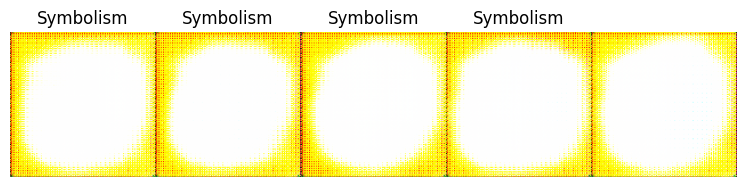

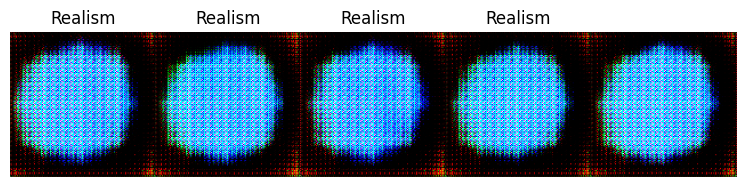

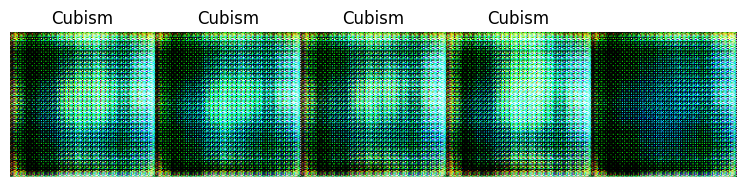

In [ ]:
#sample generation
gen.to(device)
gen.eval()
sample_size=5

first_class = "High Renaissance" # @param ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance'] {type:"string"}
second_class = "Impressionism" # @param ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance'] {type:"string"}
third_class = "Symbolism" # @param ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance'] {type:"string"}
fourth_class = "Realism" # @param ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance'] {type:"string"}
fifth_class = "Cubism" # @param ['Northern Renaissance', 'Impressionism', 'Expressionism', 'Byzantine Art', 'Pop Art', 'Baroque', 'Social Realism', 'Realism', 'Symbolism', 'Mannerism', 'Romanticism', 'Primitivism', 'Post-Impressionism', 'Proto Renaissance', 'Abstract Expressionism', 'Surrealism', 'Suprematism', 'High Renaissance', 'Cubism', 'Neoplasticism', 'Early Renaissance'] {type:"string"}

wanted_classes = [first_class, second_class, third_class, fourth_class, fifth_class]

for i in wanted_classes:
    labels = torch.ones(sample_size, device=device) * class_to_idx[i]
    fixed_z = gen.get_noise(n_samples=sample_size, z_dim=z_dim, device=device)    
    sample_image = gen(fixed_z, labels.to(torch.int64))
    print_tensor_images(sample_image, i)